In [23]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import warnings
import seaborn as sns
# To suppress all warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import  r2_score as r2
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [24]:
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

In [25]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def data_manupulation(df):
    dff = df.copy()
    dff = dff[['Yksz','Vz','Mstar', 'M','Vlos','Ytsz']]
    dff.Vz = dff.Vz.apply(lambda x: x/1e5)
    dff.Mstar = dff.Mstar.apply(lambda x: np.log(x))
    q_list = [0,0.25,0.5,0.75,1]
    labels = [1,2,3,4]
    dff['M_q'] = pd.qcut(dff['M'],q=q_list,labels=labels)
    return dff

In [28]:
snaps = ['140','116','096']

In [29]:
boxno = 50

In [30]:
df_140 = Analysis(boxno,'140','').get_dataframe()
#df_132 = Analysis(boxno,'116','').get_dataframe()
#df_096 = Analysis(boxno,'096','').get_dataframe()

In [31]:
df_140_m = data_manupulation(df_140)
#df_132_m = data_manupulation(df_132)
#df_096_m = data_manupulation(df_096)

In [84]:
np.polyfit(df_140.M, df_140.Ytsz/df_140.Yksz, 1)

array([-0.04867024,  2.43755796])

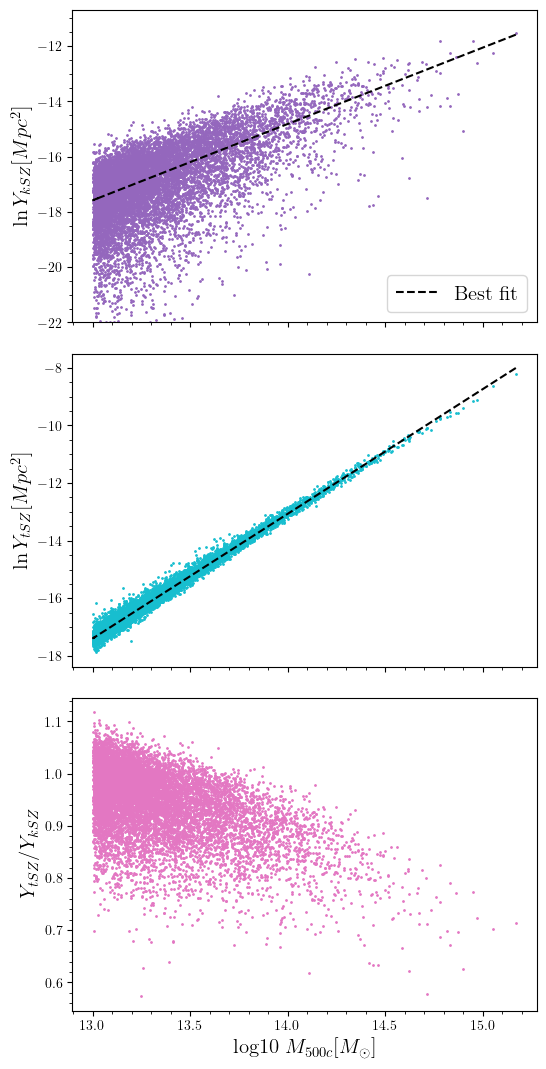

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(6, 13), sharex=True)
plt.subplots_adjust(hspace=0.1)
ax1.scatter(np.log10(np.exp(df_140.M)),df_140.Yksz,s=1,c='C4')
ax1.plot(np.log10(np.exp(df_140.M)),df_140.M*1.20 - 53.5,lw=1.5,c='k',ls='--',label='$\\rm Best\;fit$')
ax1.set_ylabel('$\ln Y_{kSZ} [Mpc^2]$',fontsize=15)
ax1.set_ylim(-22)
ax1.legend(loc='lower right',fontsize=15)
ax2.scatter(np.log10(np.exp(df_140.M)),df_140.Ytsz,s=1,c='C9')
ax2.plot(np.log10(np.exp(df_140.M)),df_140.M*(1.88) - 73.67,lw=1.5,c='k',ls='--',label='$\\rm Best\;fit$')
ax2.set_ylabel('$\ln Y_{tSZ} [Mpc^2]$',fontsize=15)
ax3.scatter(np.log10(np.exp(df_140.M)),df_140.Ytsz/df_140.Yksz,s=1,c='C6')
#ax3.plot(np.log10(np.exp(df_140.M)),df_140.M*(-0.06) + 1.,lw=1.5,c='k',ls='--',label='$\\rm Best\;fit$')
ax3.set_ylabel('$Y_{tSZ}/Y_{kSZ}$',fontsize=15)
ax3.set_xlabel('$\mathrm{log10}\; M_{500c} [M_\\odot]$',fontsize=15)
fig.savefig('ksz_tsz.pdf',dpi=300,bbox_inches='tight')

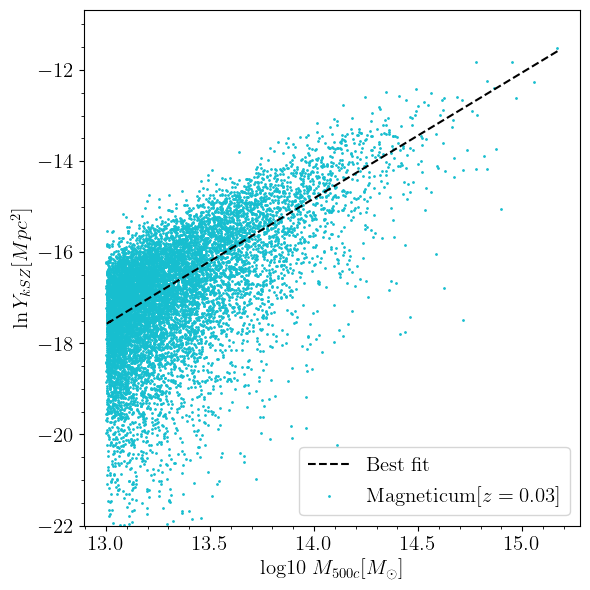

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(np.log10(np.exp(df_140.M)),df_140.Yksz,s=1,c='C9',label='$\\rm Magneticum $'+'$[z=0.03]$')
plt.plot(np.log10(np.exp(df_140.M)),df_140.M*1.20 - 53.5,lw=1.5,c='k',ls='--',label='$\\rm Best\;fit$')
plt.ylim(-22)
plt.xlabel('$\mathrm{log10}\; M_{500c} [M_\\odot]$',fontsize=15)
plt.ylabel('$\ln Y_{kSZ} [Mpc^2]$',fontsize=15)
plt.legend(fontsize=15,loc='lower right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Yksz_M_140.pdf',dpi=300,bbox_inches='tight')

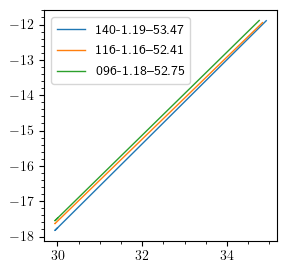

In [14]:
plt.figure(figsize=(3,3))
i = 0
rmse = []
r2 = []
for df in [df_140_m,df_132_m,df_096_m]:
    slope, intercept = np.polyfit(df.M, df.Yksz, 1)
    best_fit_line = slope*df.M+intercept
    rmse.append(mean_squared_error(df.Yksz, best_fit_line,squared=False))
    r2.append(r2_score(df.Yksz, best_fit_line))
    plt.plot(df.M, best_fit_line,linewidth=1,label=f'{snaps[i]}-{slope:.2f}-{intercept:.2f}')
    i+=1
plt.legend()

In [15]:
rmse

[1.144756036078561, 1.1184907779106839, 1.1244581168776409]

In [16]:
r2

[0.34849521792878235, 0.32238343273610315, 0.3025901128859617]

In [17]:
def fit_regression_models(df, features, target):
    print(f'Features: {features}')
    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=df.M_q, random_state=42)

    # Initialize regression models
    models = {
        "Random Forest Regression": RandomForestRegressor(max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=200, random_state=42),
        "XGB": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "GradientBoost": GradientBoostingRegressor(random_state=42),
        }

    results = {}

    for model_name, model in models.items():
        # Fit the model
        # if model_name == "Perceptron":
        #     model.fit(X_train, y_train,)
        # else:
        model.fit(X_train, y_train,sample_weight=np.sqrt(X_train[:,0]))

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        mse_test =  mean_squared_error(y_test, y_pred,squared=True)
        mse_train = mean_squared_error(y_train, y_pred_train,squared=True)
        #r2_test = r2_score(y_test, y_pred)
        #r2_train = r2_score(y_train, y_pred_train)

        results[model_name] = {"MSE_train": mse_train, "MSE_test": mse_test,}#"R2_train": r2_train, "R2_test": r2_test}

    return results

In [18]:
def get_results(df):
    results_M = fit_regression_models(df, ['M'], 'Yksz')
    results_MM = fit_regression_models(df, ['M','Mstar'], 'Yksz')
    results_MVz = fit_regression_models(df, ['M', 'Vz'], 'Yksz')
    results_MMVz = fit_regression_models(df, ['M', 'Mstar', 'Vz'], 'Yksz')
    return results_M,results_MM,results_MVz,results_MMVz


In [19]:
def dicresults(results_M, results_MM, results_MVz, results_MMVz):
    res = {}
    for feature_set, result in zip(['M','[M,Mstar]','[M, Vz]', '[M, Mstar, Vz]'],
                                [results_M, results_MM, results_MVz, results_MMVz]):
        res[feature_set]  = result
    return res

In [20]:
red_results = {}
for df,z in zip([df_140_m,df_132_m,df_096_m],['0.03','0.25','0.47']):
    res = dicresults(*get_results(df))
    red_results[z] = res

Features: ['M']
Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Features: ['M']
Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Features: ['M']
Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']


In [21]:
mse_data = red_results

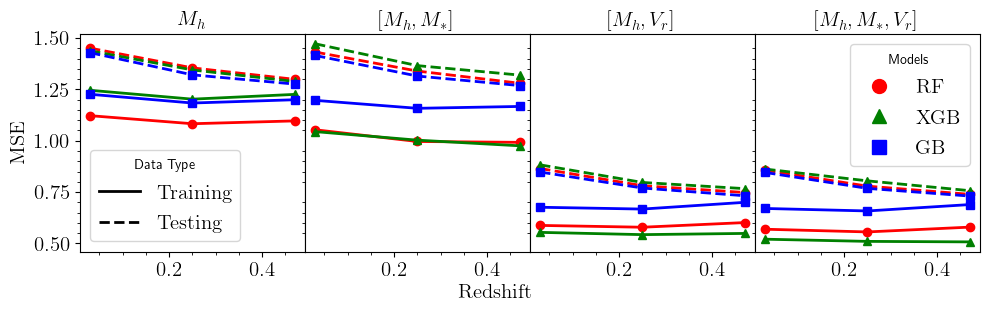

In [22]:
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

# Assuming `mse_data` is the dictionary containing your data

# Define positions for each feature set, might need to adjust based on your actual feature names
positions = ['M', '[M,Mstar]', '[M, Vz]', '[M, Mstar, Vz]']
plabels = ['$M_h$', '$[M_h,M_*]$', '$[M_h, V_r]$', '$[M_h, M_*, V_r]$']
mname = ['$\\rm RF$','$\\rm XGB$','$\\rm GB$']

# Set up the figure
fig, axs = plt.subplots(nrows=1, ncols=len(positions), figsize=(10, 3), sharey=True)

# Define colors and markers for each model
model_colors = {'Random Forest Regression': 'red', 'XGB': 'green', 'GradientBoost': 'blue'}
model_markers = {'Random Forest Regression': 'o', 'XGB': '^', 'GradientBoost': 's'}

# Define line styles for train and test
line_styles = {'train': '-', 'test': '--'}

# Plotting the data
for feature_index, feature_name in enumerate(positions):
    ax = axs[feature_index]
    for model_name in ['Random Forest Regression', 'XGB', 'GradientBoost']:
        # Extract the MSE values for training and testing across all redshifts for the current model and feature set
        redshifts = []
        mse_train_values = []
        mse_test_values = []
        for redshift, features_data in mse_data.items():
            mse_train_values.append(features_data[feature_name][model_name]['MSE_train'])
            mse_test_values.append(features_data[feature_name][model_name]['MSE_test'])
            redshifts.append(float(redshift))
        
        # Sort the arrays by redshift
        sorted_indices = np.argsort(redshifts)
        redshifts = np.array(redshifts)[sorted_indices]
        mse_train_values = np.array(mse_train_values)[sorted_indices]
        mse_test_values = np.array(mse_test_values)[sorted_indices]
        
        # Plot training and testing MSE values
        ax.plot(redshifts, mse_train_values, marker=model_markers[model_name], color=model_colors[model_name], linestyle=line_styles['train'], linewidth=2)
        ax.plot(redshifts, mse_test_values, marker=model_markers[model_name], color=model_colors[model_name], linestyle=line_styles['test'], linewidth=2)

    # Set the title for each subplot
    ax.set_title(f'{plabels[feature_index]}', fontsize=15)

    plt.xticks(fontsize=15) 
   
    
    # Remove the left spine (y-axis line) for subplots from the second to the last
    if feature_index > 0:
        #ax.spines['left'].set_visible(False)
        if feature_index < 3:
            pass
            #ax.spines['right'].set_visible(False)
        ax.tick_params(left=False)
        
    if feature_index == 0:
        ax.set_ylabel('$\\rm MSE$', fontsize=15)
        #ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=15)
    # Remove the x-axis label for all subplots
    ax.set_xlabel('')



# Set a common x-axis label in the center of the figure
fig.text(0.5, -0.01, '$\\rm Redshift$', ha='center', fontsize=15)

# Create two legends
legend_elements_1 = [
    plt.Line2D([0], [0], color='black', linestyle=line_styles['train'], linewidth=2, label='$\\rm Training$'),
    plt.Line2D([0], [0], color='black', linestyle=line_styles['test'], linewidth=2, label='$\\rm Testing$')
]

legend_elements_2 = [plt.Line2D([0], [0], marker=model_markers[name], color=model_colors[name], linestyle='None', markersize=10, label=mname[i]) for i,name in enumerate(model_markers)]

# Place the first legend in the left-most subplot
axs[0].legend(handles=legend_elements_1, loc='lower left', title='Data Type', fontsize=15)

# Place the second legend in the right-most subplot
axs[-1].legend(handles=legend_elements_2, loc='upper right', title='Models', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
# Show the plot
plt.savefig('mse.pdf',dpi=300,bbox_inches='tight')


In [18]:
mse_data

{'0.03': {'M': {'Random Forest Regression': {'MSE_train': 1.1219798330225546,
    'MSE_test': 1.4510713804762168},
   'XGB': {'MSE_train': 1.2456772532880676, 'MSE_test': 1.4381902901695516},
   'GradientBoost': {'MSE_train': 1.2262090466339732,
    'MSE_test': 1.4289522289918875}},
  '[M,Mstar]': {'Random Forest Regression': {'MSE_train': 1.05333094465027,
    'MSE_test': 1.4321597139305708},
   'XGB': {'MSE_train': 1.0442889783006617, 'MSE_test': 1.472255366819809},
   'GradientBoost': {'MSE_train': 1.1966324774784862,
    'MSE_test': 1.4152316604833488}},
  '[M, Vz]': {'Random Forest Regression': {'MSE_train': 0.5873974237084834,
    'MSE_test': 0.864619307598669},
   'XGB': {'MSE_train': 0.5535024705075624, 'MSE_test': 0.8824393900367211},
   'GradientBoost': {'MSE_train': 0.6758649980111314,
    'MSE_test': 0.8474620888222217}},
  '[M, Mstar, Vz]': {'Random Forest Regression': {'MSE_train': 0.5688288747377075,
    'MSE_test': 0.8562915610932397},
   'XGB': {'MSE_train': 0.52023314

In [19]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_140_m)

Features: ['M']


Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']


In [20]:
dicresults(results_M,results_MM,results_MVz,results_MMVz)

{'M': {'Random Forest Regression': {'MSE_train': 1.1219798330225546,
   'MSE_test': 1.4510713804762168},
  'XGB': {'MSE_train': 1.2456772532880676, 'MSE_test': 1.4381902901695516},
  'GradientBoost': {'MSE_train': 1.2262090466339732,
   'MSE_test': 1.4289522289918875}},
 '[M,Mstar]': {'Random Forest Regression': {'MSE_train': 1.05333094465027,
   'MSE_test': 1.4321597139305708},
  'XGB': {'MSE_train': 1.0442889783006617, 'MSE_test': 1.472255366819809},
  'GradientBoost': {'MSE_train': 1.1966324774784862,
   'MSE_test': 1.4152316604833488}},
 '[M, Vz]': {'Random Forest Regression': {'MSE_train': 0.5873974237084834,
   'MSE_test': 0.864619307598669},
  'XGB': {'MSE_train': 0.5535024705075624, 'MSE_test': 0.8824393900367211},
  'GradientBoost': {'MSE_train': 0.6758649980111314,
   'MSE_test': 0.8474620888222217}},
 '[M, Mstar, Vz]': {'Random Forest Regression': {'MSE_train': 0.5688288747377075,
   'MSE_test': 0.8562915610932397},
  'XGB': {'MSE_train': 0.5202331479973682, 'MSE_test': 0.86

In [21]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_132_m)

Features: ['M']


Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']


In [22]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_096_m)
# Print and compare the results
for feature_set, result in zip(['M', '[M,Mstar]','[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M,results_MM, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

Features: ['M']
Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Results for M:


KeyError: 'RMSE'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


In [ ]:
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

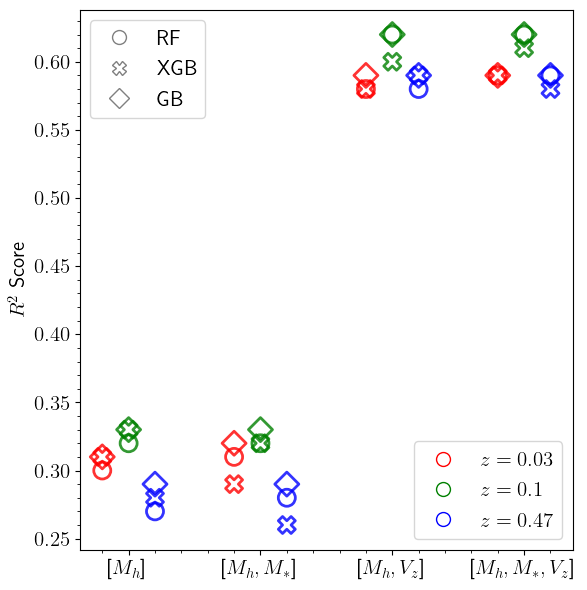

In [45]:

# Data for R2 scores
parameters = ['[M_h]', '[M_h,M_*]', '[M_h,V_z]', '[M_h,M_*,V_z]']
labels = ['[$M_h$]', '[$M_h,M_*$]', '[$M_h,V_z$]', '[$M_h,M_*,V_z$]']

# R2 scores for each model and redshift
scores = {
    'RF': {
        '0.03': [0.30, 0.31, 0.58, 0.59],
        '0.1': [0.32, 0.32, 0.62, 0.62],
        '0.47': [0.27, 0.28, 0.58, 0.59]
    },
    'XGB': {
        '0.03': [0.31, 0.29, 0.58, 0.59],
        '0.1': [0.33, 0.32, 0.60, 0.61],
        '0.47': [0.28, 0.26, 0.59, 0.58]
    },
    'GB': {
        '0.03': [0.31, 0.32, 0.59, 0.59],
        '0.1': [0.33, 0.33, 0.62, 0.62],
        '0.47': [0.29, 0.29, 0.59, 0.59]
    }
}

# Colors and markers for the plots
markers = {'RF': 'o', 'XGB': 'X', 'GB': 'D'}  # o: circle, X: x-mark, D: diamond
redshifts = ['0.03', '0.1', '0.47']
colors = ['red', 'green', 'blue']  # Colors for redshifts 0.03, 0.1, 0.47 respectively

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Set the positions of the x-ticks for each parameter set
x = np.arange(len(parameters))
width = 0.2  # the width of the bars

# Plot each model's performance with outlined markers
for i, (model, marker) in enumerate(markers.items()):
    for j, redshift in enumerate(redshifts):
        # Calculate bar positions
        positions = x - (1 - j) * width if j < 2 else x + (j - 1) * width
        # Plot each set of parameters
        ax.scatter(positions, scores[model][redshift], alpha=0.8, label=f'{model} (z={redshift})', 
                   edgecolor=colors[j], marker=marker, facecolors='none', s=150, linewidths=2)

# Customize the axes and labels
ax.set_xticks(x,)
ax.set_xticklabels(labels, fontsize=15)
#ax.set_xlabel('Parameters Used in Regression', fontsize=14)
ax.set_ylabel(r'$R^2$ Score', fontsize=15)

# Creating a custom legend for the regression methods
legend_elements_models = [Line2D([0], [0], marker='o', color='w', label='RF', markerfacecolor='none', markeredgecolor='grey', markersize=10),
                          Line2D([0], [0], marker='X', color='w', label='XGB', markerfacecolor='none', markeredgecolor='grey', markersize=10),
                          Line2D([0], [0], marker='D', color='w', label='GB', markerfacecolor='none', markeredgecolor='grey', markersize=10)]

# Creating a custom legend for the redshifts
legend_elements_redshifts = [Line2D([0], [0], marker='o', color='w', label='$z = 0.03$', markerfacecolor='none', markeredgecolor='red', markersize=10),
                             Line2D([0], [0], marker='o', color='w', label='$z = 0.1$', markerfacecolor='none', markeredgecolor='green', markersize=10),
                             Line2D([0], [0], marker='o', color='w', label='$z = 0.47$', markerfacecolor='none', markeredgecolor='blue', markersize=10)]

# Add legends to the plot
legend1 = ax.legend(handles=legend_elements_models,  loc='upper left',fontsize=15) #title="Regression Methods"
legend2 = ax.legend(handles=legend_elements_redshifts, loc='lower right',fontsize=15)#, title="Redshifts"
plt.gca().add_artist(legend1)
plt.yticks(fontsize=15)
# Show plot with a tight layout
plt.tight_layout()
plt.savefig('r2.pdf',dpi=300)


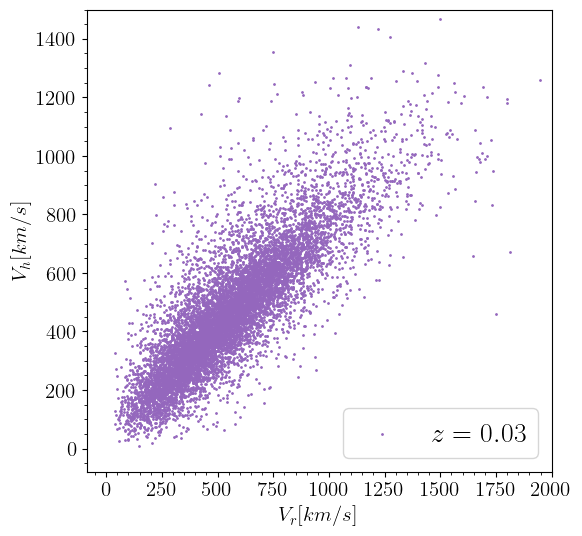

In [74]:
plt.figure(figsize=(6,6))
plt.scatter(df_140.Vnet/1e5,df_140.vnet,s=1,c='C4',label='$z=0.03$')
plt.xlabel('$V_{r}[km/s]$',fontsize=15)
plt.ylabel('$V_{h}[km/s]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(None,2000)
plt.ylim(None,1500)
plt.legend(fontsize=20)
plt.savefig('vr_vh.pdf',dpi=300)


In [73]:
np.corrcoef(df_140.Vnet/1e5,df_140.vnet)

array([[1.        , 0.84388103],
       [0.84388103, 1.        ]])